In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import os.path
import skimage
import skimage.segmentation
import sklearn.preprocessing
import sklearn.model_selection
import math
import shutil
import pathlib
import glob
import shutil
import uuid
import random
import platform
import torch
import torchvision
import numpy as np
import scipy as sp
import scipy.io
import scipy.signal
import pandas as pd
import networkx
import wfdb
import json
import tqdm
import dill
import pickle
import matplotlib.pyplot as plt

import scipy.stats
import cv2

import src.data
import src.metrics
import sak
import sak.signal.wavelet
import sak.data
import sak.data.augmentation
import sak.data.preprocessing
import sak.visualization
import sak.visualization.signal
import sak.torch
import sak.torch.nn
import sak.torch.nn as nn
import sak.torch.nn
import sak.torch.train
import sak.torch.data
import sak.torch.models
import sak.torch.models.lego
import sak.torch.models.variational
import sak.torch.models.classification

from sak.signal import StandardHeader

# Read all common files

In [3]:
basedir = '/media/guille/DADES/DADES/Delineator/'

with open('../list_files.txt') as f:
    valid_models = f.read().splitlines()
    
folders = [os.path.join(basedir,'TrainedModels',model) for model in valid_models]
all_databases = ["qtdb_single","qtdb_multi","zhejiang","ludb"]
all_waves = ["P","QRS","T"]
all_12_leads = ["zhejiang", "ludb"]
all_qtdb = ["qtdb_single","qtdb_multi"]

# Read number of model parameters

In [4]:
parameters = {}

for i,model_name in tqdm.tqdm(enumerate(valid_models)):
    savepath = os.path.join(basedir,'TrainedModels',model_name,'parameters.txt')
    
    if os.path.isfile(savepath):
        with open(savepath) as f:
            parameters[model_name] = int(f.read())

parameters = pd.Series(parameters)

109it [00:01, 83.89it/s]


# Read and homoginize results - extract

In [5]:
zhejiang = {}
ludb = {}
qtdb_single = {}
qtdb_multi = {}
qtdb_fold_single = {}
qtdb_fold_multi = {}

for counter,folder in tqdm.tqdm(enumerate(folders)):
    if (
        (not os.path.isfile(os.path.join(folder,'metrics_string.txt'))) or
        (not os.path.isfile(os.path.join(folder,'zhejiang_metrics_string.txt'))) or
        (not os.path.isfile(os.path.join(folder,'ludb_metrics_string.txt'))) or
        (not os.path.isfile(os.path.join(folder,'metrics_fold_string.txt')))
       ):
        continue
    
    # Extract model name from folder path
    root,model_name = os.path.split(folder)
    
    # Init metrics
    zhejiang[model_name] = {'P': {}, 'QRS': {}, 'T': {}}
    ludb[model_name] = {'P': {}, 'QRS': {}, 'T': {}}
    qtdb_single[model_name] = {'P': {}, 'QRS': {}, 'T': {}}
    qtdb_multi[model_name] = {'P': {}, 'QRS': {}, 'T': {}}
    qtdb_fold_single[model_name] = {'P': {}, 'QRS': {}, 'T': {}}
    qtdb_fold_multi[model_name] = {'P': {}, 'QRS': {}, 'T': {}}
    
    # Open metrics files
    with open(os.path.join(folder,'metrics_string.txt')) as f:
        metrics = f.read().splitlines()
    with open(os.path.join(folder,'metrics_fold_string.txt')) as f:
        metrics_fold = f.read().splitlines()
    with open(os.path.join(folder,'zhejiang_metrics_string.txt')) as f:
        metrics_zhejiang = f.read().splitlines()
    with open(os.path.join(folder,'ludb_metrics_string.txt')) as f:
        metrics_ludb = f.read().splitlines()
    
    # Agglomerate Zhejiang's and LUDB's metrics
    for i,db in enumerate(all_12_leads):
        dic = eval(db)
        mtr = eval(f"metrics_{db}")
        
        for j,wave in enumerate(all_waves):
            dic[model_name][wave]["Precision"] = float(mtr[4+j*10].split(':')[1][:-1])
            dic[model_name][wave]["Recall"]    = float(mtr[5+j*10].split(':')[1][:-1])
            dic[model_name][wave]["F1 Score"]  = float(mtr[6+j*10].split(':')[1][:-1])

            onmstd = mtr[8+j*10].split(':')[1][:-2]
            offmstd = mtr[9+j*10].split(':')[1][:-2]
            dic[model_name][wave]["Onset Error (Mean)"] = float(onmstd.split('±')[0])
            dic[model_name][wave]["Onset Error (STD)"] = float(onmstd.split('±')[1])
            dic[model_name][wave]["Offset Error (Mean)"] = float(offmstd.split('±')[0])
            dic[model_name][wave]["Offset Error (STD)"] = float(offmstd.split('±')[1])
    
    # Extract QTDB single and multi
    for i,type in enumerate(all_qtdb):
        dic = eval(type)
        
        for j,wave in enumerate(all_waves):
            dic[model_name][wave]["Precision"] = float(metrics[(34*i)+(7+j*10)].split(':')[1][:-1])
            dic[model_name][wave]["Recall"]    = float(metrics[(34*i)+(8+j*10)].split(':')[1][:-1])
            dic[model_name][wave]["F1 Score"]  = float(metrics[(34*i)+(9+j*10)].split(':')[1][:-1])

            onmstd = metrics[(34*i)+(11+j*10)].split(':')[1][:-2]
            offmstd = metrics[(34*i)+(12+j*10)].split(':')[1][:-2]
            dic[model_name][wave]["Onset Error (Mean)"] = float(onmstd.split('±')[0])
            dic[model_name][wave]["Onset Error (STD)"] = float(onmstd.split('±')[1])
            dic[model_name][wave]["Offset Error (Mean)"] = float(offmstd.split('±')[0])
            dic[model_name][wave]["Offset Error (STD)"] = float(offmstd.split('±')[1])


109it [00:02, 43.53it/s]


# Analyze results - best F1 score overall

In [6]:
P_F1   = {}
QRS_F1 = {}
T_F1   = {}

for wave in ["P", "QRS", "T"]:
    output = eval(f"{wave}_F1")
    
    for db in ["qtdb_single","qtdb_multi","zhejiang","ludb"]:
        database = eval(db)
        if db not in output:
            output[db] = {}

        for k in database:
            output[db][k] = database[k][wave]["F1 Score"]
            
# Convert to DataFrame
P_F1   = pd.DataFrame(P_F1)
QRS_F1 = pd.DataFrame(QRS_F1)
T_F1   = pd.DataFrame(T_F1)

# Mean results across all databases and waves
F1_overall = (P_F1.mean(axis=1)+QRS_F1.mean(axis=1)+T_F1.mean(axis=1))/3

# Display results
print(("BEST ", F1_overall.idxmax(), F1_overall.max()))
print(("WORST", F1_overall.idxmin(), F1_overall.min()))
print("\n")

# Per wave
for wave in all_waves:
    wv = eval(f"{wave}_F1")
    print(f"########## {wave} wave ##########")
    print(("BEST ", wv.mean(axis=1).idxmax(), wv.mean(axis=1).max()))
    print(("WORST", wv.mean(axis=1).idxmin(), wv.mean(axis=1).min()))
    print("\n")


('BEST ', 'UNet7LevelsConvDiceOnly_20201203124825', 99.38250000000001)
('WORST', 'UNet7LevelsDiceOnly_20201202071040', 95.16250000000001)


########## P wave ##########
('BEST ', 'WNet5LevelsSelfAttentionDiceOnly_20201130125349', 98.99000000000001)
('WORST', 'UNet7LevelsDiceOnly_20201202071040', 85.98750000000001)


########## QRS wave ##########
('BEST ', 'UNet7Levels_synth_20201208095004', 99.8475)
('WORST', 'WNet5LevelsSelfAttention_synth_20201206012731', 99.35749999999999)


########## T wave ##########
('BEST ', 'UNet7LevelsDiceOnly_20201202071040', 99.69)
('WORST', 'UNet5LevelsConvDiceOnly_real_20201204204042', 96.95750000000001)




In [7]:
F1_sort = F1_overall.sort_values()
F1_list = list(F1_sort.index)
# try:
#     F1_list.remove('UNet5LevelsConvDiceOnly_20201202003451')
# except:
#     pass
list(zip(F1_list,F1_sort[F1_list].values, parameters[F1_list].values))

[('UNet7LevelsDiceOnly_20201202071040', 95.16250000000001, 3541319),
 ('UNet7LevelsDiceOnly_synth_20201212143531', 95.66916666666667, 3541319),
 ('UNet6Levels_synth_20201207160352', 96.3875, 896327),
 ('UNet5LevelsConvDiceOnly_real_20201204204042', 97.96583333333335, 658179),
 ('UNet6LevelsDiceOnly_20201202004750', 98.00416666666666, 896327),
 ('UNet5LevelsDiceOnly_real_20201203140435', 98.07333333333334, 229191),
 ('WNet5LevelsSelfAttentionConvDiceOnly_real_20201203231939',
  98.22083333333332,
  1578236),
 ('UNet7LevelsConv_real_20201129035943', 98.29583333333333, 10502403),
 ('UNet6LevelsConvDiceOnly_real_20201205031809', 98.30583333333334, 2628867),
 ('UNet5LevelsConv_real_20201128082143', 98.32499999999999, 658179),
 ('UNet7LevelsConvDiceOnly_real_20201205081529', 98.325, 10502403),
 ('UNet5LevelsDiceOnly_synth_20201209121447', 98.39416666666666, 229191),
 ('UNet5Levels_real_20201127152623', 98.41583333333334, 229191),
 ('WNet5LevelsSelfAttentionDiceOnly_real_20201203192805',
  98

In [8]:
parameters_sort = parameters[F1_list].sort_values()
parameters_list = list(parameters_sort.index)
# try:
#     parameters_list.remove('UNet5LevelsConvDiceOnly_20201202003451')
# except:
#     pass
list(zip(parameters_list,F1_overall[parameters_list].values, parameters[parameters_list].values))

[('UNet5Levels_20201124143433', 98.74916666666667, 229191),
 ('UNet5LevelsDiceOnly_real_20201203140435', 98.07333333333334, 229191),
 ('UNet5LevelsDiceOnly_synth_20201209121447', 98.39416666666666, 229191),
 ('UNet5Levels_real_20201127152623', 98.41583333333334, 229191),
 ('UNet5LevelsDiceOnly_20201130125350', 98.64999999999999, 229191),
 ('UNet5Levels_synth_20201205163610', 98.58, 229191),
 ('WNet5Levels_20201124143434', 99.22583333333334, 547527),
 ('WNet5LevelsDiceOnly_20201130125349', 99.1375, 547527),
 ('WNet5Levels_synth_20201205201348', 99.05416666666666, 547527),
 ('WNet5LevelsDiceOnly_synth_20201209185735', 99.03750000000001, 547527),
 ('WNet5Levels_real_20201127155141', 98.8125, 547527),
 ('WNet5LevelsDiceOnly_real_20201203185909', 98.67833333333333, 547527),
 ('WNet5LevelsSelfAttention_20201124143433', 99.27499999999999, 547712),
 ('WNet5LevelsSelfAttentionDiceOnly_synth_20201209215314',
  99.17083333333335,
  547712),
 ('WNet5LevelsSelfAttention_real_20201127200934', 98.808

In [9]:
# function for setting the colors of the box plots pairs
def setBoxColors_3(bp):
    pylab.setp(bp['boxes'][0], color='blue')
    pylab.setp(bp['caps'][0], color='blue')
    pylab.setp(bp['caps'][1], color='blue')
    pylab.setp(bp['whiskers'][0], color='blue')
    pylab.setp(bp['whiskers'][1], color='blue')
    pylab.setp(bp['fliers'][0], color='blue')
    pylab.setp(bp['medians'][0], color='blue')

    pylab.setp(bp['boxes'][1], color='red')
    pylab.setp(bp['caps'][2], color='red')
    pylab.setp(bp['caps'][3], color='red')
    pylab.setp(bp['whiskers'][2], color='red')
    pylab.setp(bp['whiskers'][3], color='red')
    pylab.setp(bp['fliers'][1], color='red')
    pylab.setp(bp['medians'][1], color='red')

    pylab.setp(bp['boxes'][2], color='magenta')
    pylab.setp(bp['caps'][4], color='magenta')
    pylab.setp(bp['caps'][5], color='magenta')
    pylab.setp(bp['whiskers'][4], color='magenta')
    pylab.setp(bp['whiskers'][5], color='magenta')
    pylab.setp(bp['fliers'][2], color='magenta')
    pylab.setp(bp['medians'][2], color='magenta')


# function for setting the colors of the box plots pairs
def setBoxColors(bp):
    pylab.setp(bp['boxes'][0], color='blue')
    pylab.setp(bp['caps'][0], color='blue')
    pylab.setp(bp['caps'][1], color='blue')
    pylab.setp(bp['whiskers'][0], color='blue')
    pylab.setp(bp['whiskers'][1], color='blue')
    pylab.setp(bp['fliers'][0], color='blue')
    pylab.setp(bp['medians'][0], color='blue')

    pylab.setp(bp['boxes'][1], color='red')
    pylab.setp(bp['caps'][2], color='red')
    pylab.setp(bp['caps'][3], color='red')
    pylab.setp(bp['whiskers'][2], color='red')
    pylab.setp(bp['whiskers'][3], color='red')
    pylab.setp(bp['fliers'][1], color='red')
    pylab.setp(bp['medians'][1], color='red')




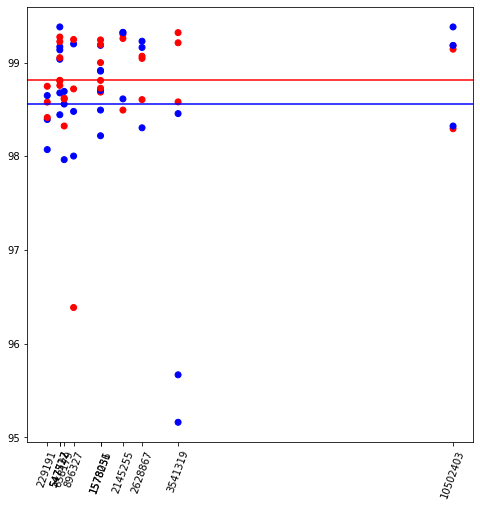

In [10]:
x = parameters[F1_list].values
y = F1_sort[F1_list].values
colors = ["b" if "DiceOnly" in name else "r" for name in F1_list]
names = ["Dice" if "DiceOnly" in name else "F1" for name in F1_list]

y_dice = y[np.array(colors) == 'b'].mean()
y_f1 = y[np.array(colors) == 'r'].mean()

plt.figure(figsize=(8,8));plt.scatter(x,y,c=colors)
plt.gca().ticklabel_format(style="plain")
plt.gca().set_xticks(np.unique(parameters[F1_list].values).tolist())
plt.gca().axhline(y_dice,color="b")
plt.gca().axhline(y_f1,color="r")
plt.xticks(rotation=70)
plt.gcf().savefig('./figures/metric_scatter_F1.svg')

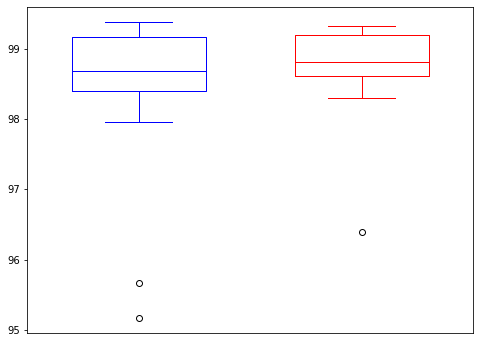

In [11]:
import pylab

x = parameters[F1_list].values
y = F1_sort[F1_list].values
n = np.array(F1_list)

f = plt.figure(figsize=(8,6))
ax = f.gca()

k = 3

ticklabels = []
tickvalues = []

y_d  = y[[j for j,name in enumerate(n) if "DiceOnly" in name]]
y_f = y[[j for j,name in enumerate(n) if "DiceOnly" not in name]]

# Plot boxes
bp = ax.boxplot([y_d,y_f],positions=[0,1], widths = 0.6)
setBoxColors(bp)
    
ax.set_xticks(tickvalues)
ax.set_xticklabels(ticklabels)

f.savefig('./figures/metric_boxplot_F1.svg')

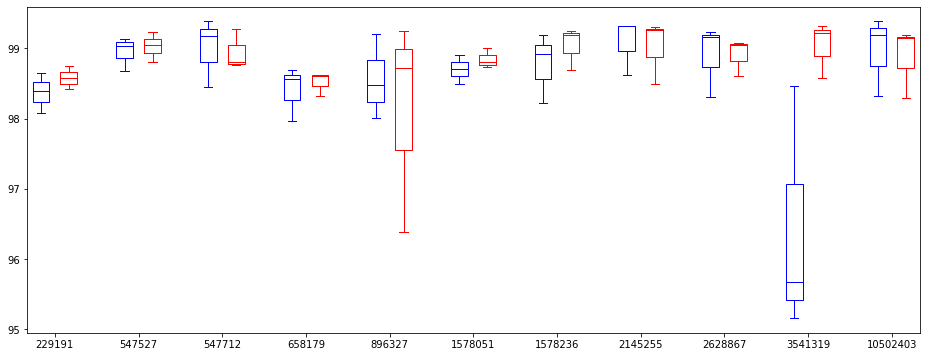

In [12]:
import pylab

x = parameters[F1_list].values
y = F1_sort[F1_list].values
n = np.array(F1_list)
# x = (np.round(x/100000)*100000).astype(int)
unique_x = np.unique(x)

f = plt.figure(figsize=(16,6))
ax = f.gca()

k = 3

ticklabels = []
tickvalues = []

for i,v in enumerate(unique_x):
    # Add tick info
    ticklabels.append(v)
    tickvalues.append(k*i+0.5)
    
    # Get specific stuff
    y_v = y[x == v]
    x_v = x[x == v]
    n_v = np.array(F1_list)[x == v]
    
    y_dice = y_v[[j for j,name in enumerate(n_v) if "DiceOnly" in name]]
    y_f1 = y_v[[j for j,name in enumerate(n_v) if "DiceOnly" not in name]]
    
    # Plot boxes
    bp = ax.boxplot([y_dice,y_f1],positions=[i*k,i*k+1], widths = 0.6)
    setBoxColors(bp)
    
ax.set_xticks(tickvalues)
ax.set_xticklabels(ticklabels)

f.savefig('./figures/metric_boxplot_by_parameters_F1.svg')

### check real vs synth vs all

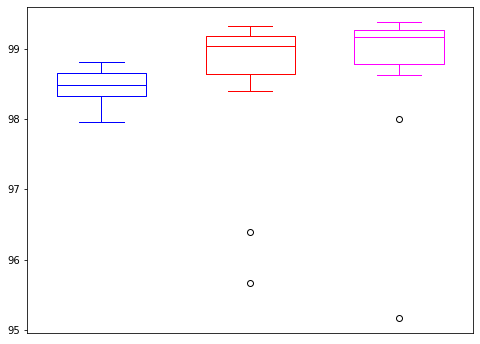

In [13]:
import pylab

# function for setting the colors of the box plots pairs
def setBoxColors_3(bp):
    pylab.setp(bp['boxes'][0], color='blue')
    pylab.setp(bp['caps'][0], color='blue')
    pylab.setp(bp['caps'][1], color='blue')
    pylab.setp(bp['whiskers'][0], color='blue')
    pylab.setp(bp['whiskers'][1], color='blue')
    pylab.setp(bp['fliers'][0], color='blue')
    pylab.setp(bp['medians'][0], color='blue')

    pylab.setp(bp['boxes'][1], color='red')
    pylab.setp(bp['caps'][2], color='red')
    pylab.setp(bp['caps'][3], color='red')
    pylab.setp(bp['whiskers'][2], color='red')
    pylab.setp(bp['whiskers'][3], color='red')
    pylab.setp(bp['fliers'][1], color='red')
    pylab.setp(bp['medians'][1], color='red')

    pylab.setp(bp['boxes'][2], color='magenta')
    pylab.setp(bp['caps'][4], color='magenta')
    pylab.setp(bp['caps'][5], color='magenta')
    pylab.setp(bp['whiskers'][4], color='magenta')
    pylab.setp(bp['whiskers'][5], color='magenta')
    pylab.setp(bp['fliers'][2], color='magenta')
    pylab.setp(bp['medians'][2], color='magenta')


x = parameters[F1_list].values
y = F1_sort[F1_list].values
n = np.array(F1_list)

f = plt.figure(figsize=(8,6))
ax = f.gca()

k = 3

ticklabels = []
tickvalues = []

y_real  = y[[j for j,name in enumerate(n) if "_real_" in name]]
y_synth = y[[j for j,name in enumerate(n) if "_synth_" in name]]
y_both  = y[[j for j,name in enumerate(n) if (("_real_" not in name) and ("_synth_" not in name))]]

# Plot boxes
bp = ax.boxplot([y_real,y_synth,y_both],positions=[0,1,2], widths = 0.6)
setBoxColors_3(bp)
    
ax.set_xticks(tickvalues)
ax.set_xticklabels(ticklabels)

f.savefig('./figures/real_synth_both_F1.svg')

### check u vs w

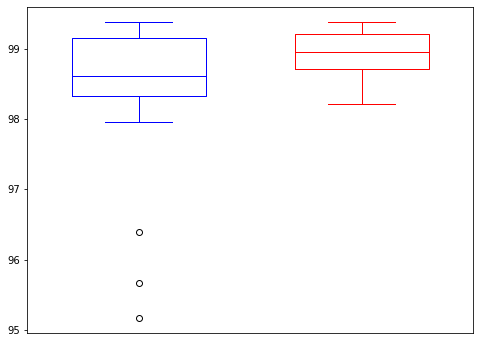

In [14]:
import pylab

# function for setting the colors of the box plots pairs
def setBoxColors_3(bp):
    pylab.setp(bp['boxes'][0], color='blue')
    pylab.setp(bp['caps'][0], color='blue')
    pylab.setp(bp['caps'][1], color='blue')
    pylab.setp(bp['whiskers'][0], color='blue')
    pylab.setp(bp['whiskers'][1], color='blue')
    pylab.setp(bp['fliers'][0], color='blue')
    pylab.setp(bp['medians'][0], color='blue')

    pylab.setp(bp['boxes'][1], color='red')
    pylab.setp(bp['caps'][2], color='red')
    pylab.setp(bp['caps'][3], color='red')
    pylab.setp(bp['whiskers'][2], color='red')
    pylab.setp(bp['whiskers'][3], color='red')
    pylab.setp(bp['fliers'][1], color='red')
    pylab.setp(bp['medians'][1], color='red')

    pylab.setp(bp['boxes'][2], color='magenta')
    pylab.setp(bp['caps'][4], color='magenta')
    pylab.setp(bp['caps'][5], color='magenta')
    pylab.setp(bp['whiskers'][4], color='magenta')
    pylab.setp(bp['whiskers'][5], color='magenta')
    pylab.setp(bp['fliers'][2], color='magenta')
    pylab.setp(bp['medians'][2], color='magenta')


x = parameters[F1_list].values
y = F1_sort[F1_list].values
n = np.array(F1_list)

f = plt.figure(figsize=(8,6))
ax = f.gca()

k = 3

ticklabels = []
tickvalues = []

y_w  = y[[j for j,name in enumerate(n) if "WNet" in name]]
y_u = y[[j for j,name in enumerate(n) if "UNet" in name]]

# Plot boxes
bp = ax.boxplot([y_u,y_w],positions=[0,1], widths = 0.6)
setBoxColors(bp)
    
ax.set_xticks(tickvalues)
ax.set_xticklabels(ticklabels)

f.savefig('./figures/u_vs_w_F1.svg')

### check 7 vs 6 vs 5

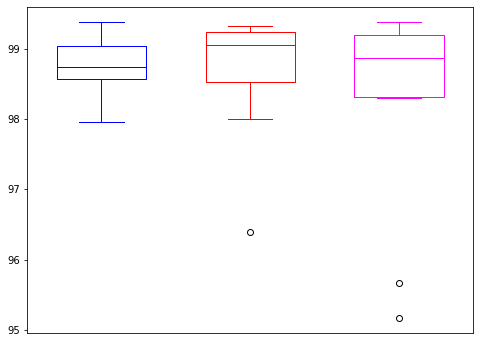

In [15]:
import pylab

# function for setting the colors of the box plots pairs
def setBoxColors_3(bp):
    pylab.setp(bp['boxes'][0], color='blue')
    pylab.setp(bp['caps'][0], color='blue')
    pylab.setp(bp['caps'][1], color='blue')
    pylab.setp(bp['whiskers'][0], color='blue')
    pylab.setp(bp['whiskers'][1], color='blue')
    pylab.setp(bp['fliers'][0], color='blue')
    pylab.setp(bp['medians'][0], color='blue')

    pylab.setp(bp['boxes'][1], color='red')
    pylab.setp(bp['caps'][2], color='red')
    pylab.setp(bp['caps'][3], color='red')
    pylab.setp(bp['whiskers'][2], color='red')
    pylab.setp(bp['whiskers'][3], color='red')
    pylab.setp(bp['fliers'][1], color='red')
    pylab.setp(bp['medians'][1], color='red')

    pylab.setp(bp['boxes'][2], color='magenta')
    pylab.setp(bp['caps'][4], color='magenta')
    pylab.setp(bp['caps'][5], color='magenta')
    pylab.setp(bp['whiskers'][4], color='magenta')
    pylab.setp(bp['whiskers'][5], color='magenta')
    pylab.setp(bp['fliers'][2], color='magenta')
    pylab.setp(bp['medians'][2], color='magenta')


x = parameters[F1_list].values
y = F1_sort[F1_list].values
n = np.array(F1_list)

f = plt.figure(figsize=(8,6))
ax = f.gca()

k = 3

ticklabels = []
tickvalues = []

y_7 = y[[j for j,name in enumerate(n) if "7Levels" in name]]
y_6 = y[[j for j,name in enumerate(n) if "6Levels" in name]]
y_5 = y[[j for j,name in enumerate(n) if "5Levels" in name]]

# Plot boxes
bp = ax.boxplot([y_5,y_6,y_7],positions=[0,1,2], widths = 0.6)
setBoxColors_3(bp)
    
ax.set_xticks(tickvalues)
ax.set_xticklabels(ticklabels)

f.savefig('./figures/5_6_7_levels_F1.svg')

# Analyze results - minimum STD

In [16]:
P_Mean_on    = {}
P_STD_on     = {}
P_Mean_off   = {}
P_STD_off    = {}
QRS_Mean_on  = {}
QRS_STD_on   = {}
QRS_Mean_off = {}
QRS_STD_off  = {}
T_Mean_on    = {}
T_STD_on     = {}
T_Mean_off   = {}
T_STD_off    = {}

for t in ["Mean", "STD"]:
    for wave in ["P", "QRS", "T"]:
        output_on  = eval(f"{wave}_{t}_on")
        output_off = eval(f"{wave}_{t}_off")

        for db in ["qtdb_single","qtdb_multi","zhejiang","ludb"]:
            database = eval(db)
            if db not in output_on:
                output_on[db] = {}
            if db not in output_off:
                output_off[db] = {}

            for k in database:
                output_on[db][k] = database[k][wave][f"Onset Error ({t})"]
                output_off[db][k] = database[k][wave][f"Offset Error ({t})"]

# Convert to DataFrame
P_Mean_on    = pd.DataFrame(P_Mean_on)
P_STD_on     = pd.DataFrame(P_STD_on)
P_Mean_off   = pd.DataFrame(P_Mean_off)
P_STD_off    = pd.DataFrame(P_STD_off)
QRS_Mean_on  = pd.DataFrame(QRS_Mean_on)
QRS_STD_on   = pd.DataFrame(QRS_STD_on)
QRS_Mean_off = pd.DataFrame(QRS_Mean_off)
QRS_STD_off  = pd.DataFrame(QRS_STD_off)
T_Mean_on    = pd.DataFrame(T_Mean_on)
T_STD_on     = pd.DataFrame(T_STD_on)
T_Mean_off   = pd.DataFrame(T_Mean_off)
T_STD_off    = pd.DataFrame(T_STD_off)

# Mean results across all databases and waves
onoff_overall = (
    ((P_STD_on+P_STD_off)/2).mean(axis=1)+
    ((QRS_STD_on+QRS_STD_off)/2).mean(axis=1)+
    ((T_STD_on+T_STD_off)/2).mean(axis=1))/3

# Display results
print(("BEST ", onoff_overall.idxmin(), onoff_overall.min()))
print(("WORST", onoff_overall.idxmax(), onoff_overall.max()))
print("\n")

# Per wave
for wave in all_waves:
    wv_on = eval(f"{wave}_STD_on")
    wv_off = eval(f"{wave}_STD_off")
    print(f"########## {wave} wave ##########")
    print(("BEST ", ((wv_on+wv_off)/2).mean(axis=1).idxmin(), ((wv_on+wv_off)/2).mean(axis=1).min()))
    print(("WORST", ((wv_on+wv_off)/2).mean(axis=1).idxmax(), ((wv_on+wv_off)/2).mean(axis=1).max()))
    print("\n")


('BEST ', 'WNet5LevelsSelfAttentionDiceOnly_20201130125349', 18.232083333333332)
('WORST', 'UNet5LevelsConvDiceOnly_20201202003451', 56.17374999999999)


########## P wave ##########
('BEST ', 'WNet5LevelsSelfAttentionConvDiceOnly_20201130125349', 12.90875)
('WORST', 'UNet5LevelsConvDiceOnly_20201202003451', 41.68)


########## QRS wave ##########
('BEST ', 'WNet5LevelsSelfAttentionDiceOnly_20201130125349', 10.479999999999999)
('WORST', 'UNet5LevelsConvDiceOnly_20201202003451', 38.32)


########## T wave ##########
('BEST ', 'UNet7LevelsConvDiceOnly_20201203124825', 30.746250000000003)
('WORST', 'UNet5LevelsConvDiceOnly_20201202003451', 88.52124999999998)




In [17]:
std_sort = onoff_overall.sort_values()
std_list = list(std_sort.index)
std_list.remove('UNet5LevelsConvDiceOnly_20201202003451')
list(zip(std_list,std_sort[std_list].values, parameters[std_list].values))

[('WNet5LevelsSelfAttentionDiceOnly_20201130125349',
  18.232083333333332,
  547712),
 ('WNet5LevelsSelfAttentionConvDiceOnly_20201130125349',
  18.295416666666668,
  1578236),
 ('UNet7LevelsConvDiceOnly_20201203124825', 18.300416666666667, 10502403),
 ('WNet5LevelsSelfAttention_20201124143433', 18.31125, 547712),
 ('WNet5LevelsSelfAttentionConv_20201124143433', 18.317916666666665, 1578236),
 ('WNet5LevelsSelfAttentionDiceOnly_synth_20201209215314',
  18.642916666666668,
  547712),
 ('WNet6LevelsDiceOnly_20201202044521', 18.739583333333332, 2145255),
 ('UNet7LevelsDiceOnly_20201202071040', 18.822916666666664, 3541319),
 ('WNet5LevelsSelfAttention_real_20201127200934', 18.82541666666667, 547712),
 ('UNet7Levels_20201126170003', 19.050416666666667, 3541319),
 ('UNet6LevelsDiceOnly_20201202004750', 19.070416666666667, 896327),
 ('UNet6LevelsConvDiceOnly_20201202055324', 19.07541666666667, 2628867),
 ('WNet6Levels_20201126051114', 19.099166666666665, 2145255),
 ('WNet5Levels_20201124143434

In [18]:
parameters_sort = parameters[std_list].sort_values()
parameters_list = list(parameters_sort.index)
list(zip(parameters_list,onoff_overall[parameters_list].values, parameters[parameters_list].values))

[('UNet5LevelsDiceOnly_real_20201203140435', 19.644583333333333, 229191),
 ('UNet5LevelsDiceOnly_synth_20201209121447', 20.235416666666666, 229191),
 ('UNet5Levels_synth_20201205163610', 20.192083333333333, 229191),
 ('UNet5Levels_20201124143433', 20.0675, 229191),
 ('UNet5Levels_real_20201127152623', 19.607083333333332, 229191),
 ('UNet5LevelsDiceOnly_20201130125350', 19.357916666666664, 229191),
 ('WNet5LevelsDiceOnly_synth_20201209185735', 20.435833333333335, 547527),
 ('WNet5Levels_synth_20201205201348', 19.934166666666666, 547527),
 ('WNet5LevelsDiceOnly_20201130125349', 19.554583333333333, 547527),
 ('WNet5LevelsDiceOnly_real_20201203185909', 19.553333333333335, 547527),
 ('WNet5Levels_real_20201127155141', 19.44875, 547527),
 ('WNet5Levels_20201124143434', 19.177916666666665, 547527),
 ('WNet5LevelsSelfAttention_synth_20201206012731', 19.5475, 547712),
 ('WNet5LevelsSelfAttentionDiceOnly_real_20201203192805',
  19.192916666666665,
  547712),
 ('WNet5LevelsSelfAttentionDiceOnly_2

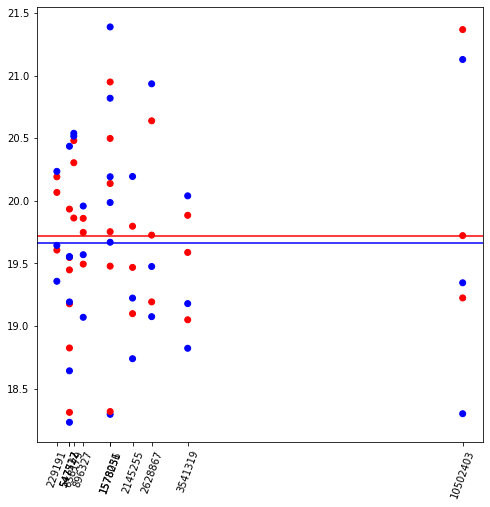

In [19]:
x = parameters[std_list].values
y = std_sort[std_list].values
colors = ["b" if "DiceOnly" in name else "r" for name in std_list]
names = ["Dice" if "DiceOnly" in name else "F1" for name in std_list]

y_dice = y[np.array(colors) == 'b'].mean()
y_f1 = y[np.array(colors) == 'r'].mean()

plt.figure(figsize=(8,8));plt.scatter(x,y,c=colors)
plt.gca().ticklabel_format(style="plain")
plt.gca().set_xticks(np.unique(parameters[std_list].values).tolist())
plt.gca().axhline(y_dice,color="b")
plt.gca().axhline(y_f1,color="r")
plt.xticks(rotation=70)
plt.gcf().savefig('./figures/metric_scatter_std.svg')

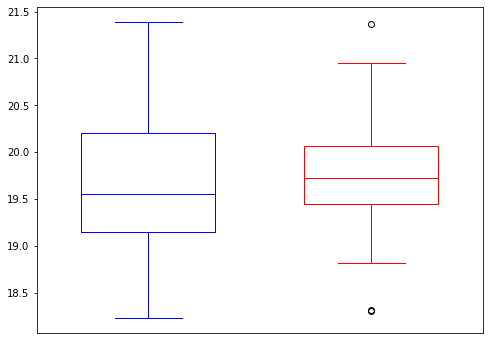

In [20]:
import pylab

x = parameters[std_list].values
y = std_sort[std_list].values
n = np.array(std_list)

f = plt.figure(figsize=(8,6))
ax = f.gca()

k = 3

ticklabels = []
tickvalues = []

y_d  = y[[j for j,name in enumerate(n) if "DiceOnly" in name]]
y_f = y[[j for j,name in enumerate(n) if "DiceOnly" not in name]]

# Plot boxes
bp = ax.boxplot([y_d,y_f],positions=[0,1], widths = 0.6)
setBoxColors(bp)
    
ax.set_xticks(tickvalues)
ax.set_xticklabels(ticklabels)

f.savefig('./figures/metric_boxplot_std.svg')

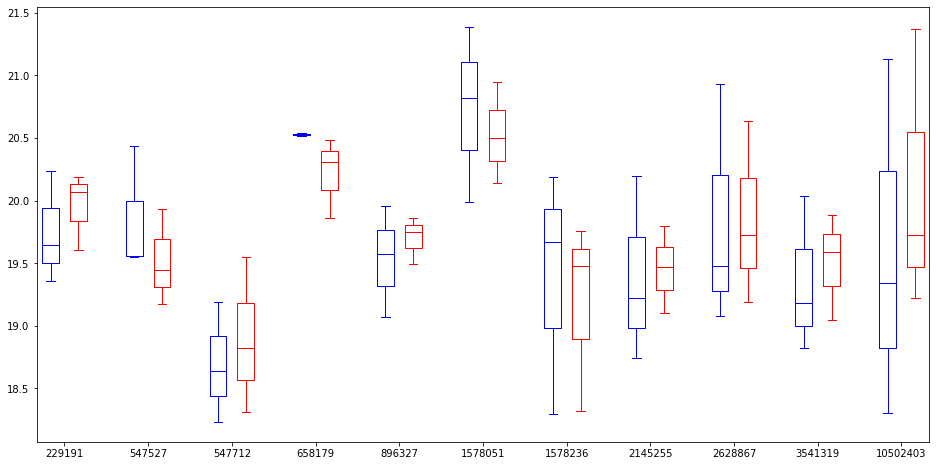

In [22]:
import pylab

# function for setting the colors of the box plots pairs
def setBoxColors(bp):
    pylab.setp(bp['boxes'][0], color='blue')
    pylab.setp(bp['caps'][0], color='blue')
    pylab.setp(bp['caps'][1], color='blue')
    pylab.setp(bp['whiskers'][0], color='blue')
    pylab.setp(bp['whiskers'][1], color='blue')
    pylab.setp(bp['fliers'][0], color='blue')
    pylab.setp(bp['medians'][0], color='blue')

    pylab.setp(bp['boxes'][1], color='red')
    pylab.setp(bp['caps'][2], color='red')
    pylab.setp(bp['caps'][3], color='red')
    pylab.setp(bp['whiskers'][2], color='red')
    pylab.setp(bp['whiskers'][3], color='red')
    pylab.setp(bp['fliers'][1], color='red')
    pylab.setp(bp['medians'][1], color='red')


x = parameters[std_list].values
y = std_sort[std_list].values
n = np.array(std_list)
x = parameters[std_list].values
# x = (np.round(x/100000)*100000).astype(int)
unique_x = np.unique(x)

f = plt.figure(figsize=(16,8))
ax = f.gca()

k = 3

ticklabels = []
tickvalues = []

for i,v in enumerate(unique_x):
    # Add tick info
    ticklabels.append(v)
    tickvalues.append(k*i+0.5)
    
    # Get specific stuff
    y_v = y[x == v]
    x_v = x[x == v]
    n_v = np.array(std_list)[x == v]
    
    y_dice = y_v[[j for j,name in enumerate(n_v) if "DiceOnly" in name]]
    y_f1 = y_v[[j for j,name in enumerate(n_v) if "DiceOnly" not in name]]
    
    # Plot boxes
    bp = ax.boxplot([y_dice,y_f1],positions=[i*k,i*k+1], widths = 0.6)
    setBoxColors(bp)
    
ax.set_xticks(tickvalues)
ax.set_xticklabels(ticklabels)

f.savefig('./figures/metric_boxplot_by_parameters_std.svg')

### check real vs synth vs all

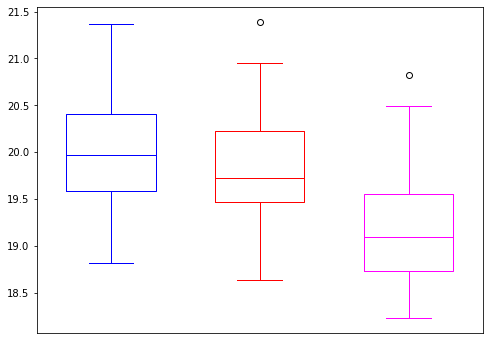

In [23]:
import pylab

# function for setting the colors of the box plots pairs
def setBoxColors_3(bp):
    pylab.setp(bp['boxes'][0], color='blue')
    pylab.setp(bp['caps'][0], color='blue')
    pylab.setp(bp['caps'][1], color='blue')
    pylab.setp(bp['whiskers'][0], color='blue')
    pylab.setp(bp['whiskers'][1], color='blue')
    pylab.setp(bp['fliers'][0], color='blue')
    pylab.setp(bp['medians'][0], color='blue')

    pylab.setp(bp['boxes'][1], color='red')
    pylab.setp(bp['caps'][2], color='red')
    pylab.setp(bp['caps'][3], color='red')
    pylab.setp(bp['whiskers'][2], color='red')
    pylab.setp(bp['whiskers'][3], color='red')
    pylab.setp(bp['fliers'][1], color='red')
    pylab.setp(bp['medians'][1], color='red')

    pylab.setp(bp['boxes'][2], color='magenta')
    pylab.setp(bp['caps'][4], color='magenta')
    pylab.setp(bp['caps'][5], color='magenta')
    pylab.setp(bp['whiskers'][4], color='magenta')
    pylab.setp(bp['whiskers'][5], color='magenta')
    pylab.setp(bp['fliers'][2], color='magenta')
    pylab.setp(bp['medians'][2], color='magenta')


x = parameters[std_list].values
y = std_sort[std_list].values
n = np.array(std_list)

f = plt.figure(figsize=(8,6))
ax = f.gca()

k = 3

ticklabels = []
tickvalues = []

y_real  = y[[j for j,name in enumerate(n) if "_real_" in name]]
y_synth = y[[j for j,name in enumerate(n) if "_synth_" in name]]
y_both  = y[[j for j,name in enumerate(n) if (("_real_" not in name) and ("_synth_" not in name))]]

# Plot boxes
bp = ax.boxplot([y_real,y_synth,y_both],positions=[0,1,2], widths = 0.6)
setBoxColors_3(bp)
    
ax.set_xticks(tickvalues)
ax.set_xticklabels(ticklabels)

f.savefig('./figures/real_synth_both_std.svg')

### check u vs w

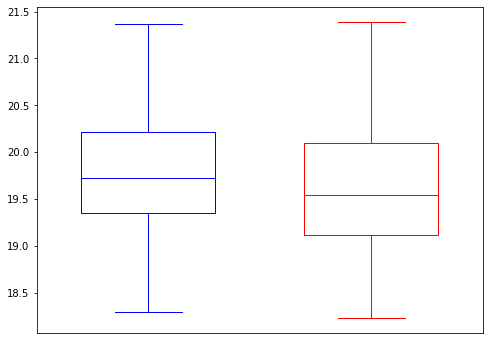

In [24]:
import pylab

# function for setting the colors of the box plots pairs
def setBoxColors_3(bp):
    pylab.setp(bp['boxes'][0], color='blue')
    pylab.setp(bp['caps'][0], color='blue')
    pylab.setp(bp['caps'][1], color='blue')
    pylab.setp(bp['whiskers'][0], color='blue')
    pylab.setp(bp['whiskers'][1], color='blue')
    pylab.setp(bp['fliers'][0], color='blue')
    pylab.setp(bp['medians'][0], color='blue')

    pylab.setp(bp['boxes'][1], color='red')
    pylab.setp(bp['caps'][2], color='red')
    pylab.setp(bp['caps'][3], color='red')
    pylab.setp(bp['whiskers'][2], color='red')
    pylab.setp(bp['whiskers'][3], color='red')
    pylab.setp(bp['fliers'][1], color='red')
    pylab.setp(bp['medians'][1], color='red')

    pylab.setp(bp['boxes'][2], color='magenta')
    pylab.setp(bp['caps'][4], color='magenta')
    pylab.setp(bp['caps'][5], color='magenta')
    pylab.setp(bp['whiskers'][4], color='magenta')
    pylab.setp(bp['whiskers'][5], color='magenta')
    pylab.setp(bp['fliers'][2], color='magenta')
    pylab.setp(bp['medians'][2], color='magenta')


x = parameters[std_list].values
y = std_sort[std_list].values
n = np.array(std_list)

f = plt.figure(figsize=(8,6))
ax = f.gca()

k = 3

ticklabels = []
tickvalues = []

y_w  = y[[j for j,name in enumerate(n) if "WNet" in name]]
y_u = y[[j for j,name in enumerate(n) if "UNet" in name]]

# Plot boxes
bp = ax.boxplot([y_u,y_w],positions=[0,1], widths = 0.6)
setBoxColors(bp)
    
ax.set_xticks(tickvalues)
ax.set_xticklabels(ticklabels)

f.savefig('./figures/u_vs_w_std.svg')

### check 7 vs 6 vs 5

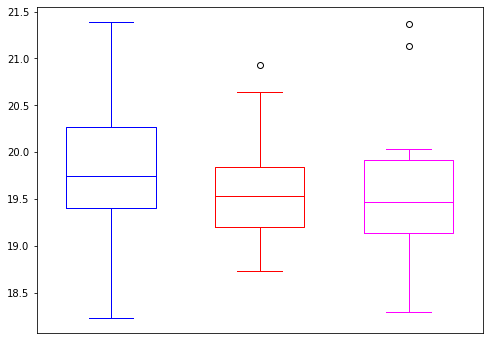

In [25]:
import pylab

# function for setting the colors of the box plots pairs
def setBoxColors_3(bp):
    pylab.setp(bp['boxes'][0], color='blue')
    pylab.setp(bp['caps'][0], color='blue')
    pylab.setp(bp['caps'][1], color='blue')
    pylab.setp(bp['whiskers'][0], color='blue')
    pylab.setp(bp['whiskers'][1], color='blue')
    pylab.setp(bp['fliers'][0], color='blue')
    pylab.setp(bp['medians'][0], color='blue')

    pylab.setp(bp['boxes'][1], color='red')
    pylab.setp(bp['caps'][2], color='red')
    pylab.setp(bp['caps'][3], color='red')
    pylab.setp(bp['whiskers'][2], color='red')
    pylab.setp(bp['whiskers'][3], color='red')
    pylab.setp(bp['fliers'][1], color='red')
    pylab.setp(bp['medians'][1], color='red')

    pylab.setp(bp['boxes'][2], color='magenta')
    pylab.setp(bp['caps'][4], color='magenta')
    pylab.setp(bp['caps'][5], color='magenta')
    pylab.setp(bp['whiskers'][4], color='magenta')
    pylab.setp(bp['whiskers'][5], color='magenta')
    pylab.setp(bp['fliers'][2], color='magenta')
    pylab.setp(bp['medians'][2], color='magenta')


x = parameters[std_list].values
y = std_sort[std_list].values
n = np.array(std_list)

f = plt.figure(figsize=(8,6))
ax = f.gca()

k = 3

ticklabels = []
tickvalues = []

y_7 = y[[j for j,name in enumerate(n) if "7Levels" in name]]
y_6 = y[[j for j,name in enumerate(n) if "6Levels" in name]]
y_5 = y[[j for j,name in enumerate(n) if "5Levels" in name]]

# Plot boxes
bp = ax.boxplot([y_5,y_6,y_7],positions=[0,1,2], widths = 0.6)
setBoxColors_3(bp)
    
ax.set_xticks(tickvalues)
ax.set_xticklabels(ticklabels)

f.savefig('./figures/5_6_7_levels_std.svg')

# Real vs synthetic vs both

In [26]:
real  = [model for model in valid_models if ("_real_" in model)]
synth = [model for model in valid_models if ("_synth_" in model)]
both  = [model for model in valid_models if ((model not in real) and (model not in synth))]

In [28]:
# metric = "F1 Score"
metric = "Offset Error (STD)"

real_as_metric = {}
synth_as_metric = {}
both_as_metric = {}

for db in all_databases:
    database = eval(db)
    
    for k in database:
        value = {wave: database[k][wave][metric] for wave in all_waves}
        unikey = k.split('_')[0]
        
        if k in real:
            value = real_as_metric.get(unikey,{})
            value.update({f"{wave}_{db}": database[k][wave][metric] for wave in all_waves})
            real_as_metric[unikey] = value
        elif k in synth:
            value = synth_as_metric.get(unikey,{})
            value.update({f"{wave}_{db}": database[k][wave][metric] for wave in all_waves})
            synth_as_metric[unikey] = value
        elif k in both:
            value = both_as_metric.get(unikey,{})
            value.update({f"{wave}_{db}": database[k][wave][metric] for wave in all_waves})
            both_as_metric[unikey] = value
        else:
            raise ValueError("This should not have happened")

# Convert to DataFrame
real_as_metric = pd.DataFrame(real_as_metric)
synth_as_metric = pd.DataFrame(synth_as_metric)
both_as_metric = pd.DataFrame(both_as_metric)

# Drop faulty training
if "UNet7LevelsDiceOnly" in real_as_metric:
    real_as_metric = real_as_metric.T.drop("UNet7LevelsDiceOnly").drop("UNet6LevelsDiceOnly").T
if "UNet7LevelsDiceOnly" in synth_as_metric:
    synth_as_metric = synth_as_metric.T.drop("UNet7LevelsDiceOnly").drop("UNet6LevelsDiceOnly").T
if "UNet7LevelsDiceOnly" in both_as_metric:
    both_as_metric = both_as_metric.T.drop("UNet7LevelsDiceOnly").drop("UNet6LevelsDiceOnly").T

# Display results
print(("BOTH VS  REAL", (both_as_metric.T-real_as_metric.T).mean(axis=1).mean()))
print(("BOTH VS SYNTH", (both_as_metric.T-synth_as_metric.T).mean(axis=1).mean()))
print(("SYNTH VS REAL", (synth_as_metric.T-real_as_metric.T).mean(axis=1).mean()))
print("\n")

# Per wave
for wave in all_waves:
    real_mtr = eval(f"real_as_metric").T[[f'{wave}_qtdb_single',f'{wave}_qtdb_multi',f'{wave}_ludb',f'{wave}_zhejiang',]].T
    synth_mtr = eval(f"synth_as_metric").T[[f'{wave}_qtdb_single',f'{wave}_qtdb_multi',f'{wave}_ludb',f'{wave}_zhejiang',]].T
    both_mtr = eval(f"both_as_metric").T[[f'{wave}_qtdb_single',f'{wave}_qtdb_multi',f'{wave}_ludb',f'{wave}_zhejiang',]].T
    print(f"########## {wave} wave ##########")
    print(("BOTH VS  REAL", (both_mtr.T-real_mtr.T).mean(axis=1).mean()))
    print(("BOTH VS SYNTH", (both_mtr.T-synth_mtr.T).mean(axis=1).mean()))
    print(("SYNTH VS REAL", (synth_mtr.T-real_mtr.T).mean(axis=1).mean()))
    print("\n")


('BOTH VS  REAL', 1.2560833333333339)
('BOTH VS SYNTH', 0.9295000000000003)
('SYNTH VS REAL', 0.3265833333333332)


########## P wave ##########
('BOTH VS  REAL', 0.3553749999999999)
('BOTH VS SYNTH', 0.8617500000000001)
('SYNTH VS REAL', -0.506375)


########## QRS wave ##########
('BOTH VS  REAL', 0.2817499999999997)
('BOTH VS SYNTH', 0.517)
('SYNTH VS REAL', -0.23525000000000001)


########## T wave ##########
('BOTH VS  REAL', 3.131125)
('BOTH VS SYNTH', 1.4097500000000003)
('SYNTH VS REAL', 1.7213749999999997)




# U-Net vs W-Net

In [65]:
metric = "Onset Error (STD)"

unet = [model for model in valid_models if ("UNet" in model)]
wnet = [model for model in valid_models if ("WNet" in model)]

unet_as_metric = {}
wnet_as_metric = {}

for db in all_databases:
    database = eval(db)
    
    for k in database:
        value = {wave: database[k][wave][metric] for wave in all_waves}
        unikey = "_".join(k.replace("UNet","").replace("WNet","").split("_")[:-1])
        
        if k in unet:
            value = unet_as_metric.get(unikey,{})
            value.update({f"{wave}_{db}": database[k][wave][metric] for wave in all_waves})
            unet_as_metric[unikey] = value
        elif k in wnet:
            value = wnet_as_metric.get(unikey,{})
            value.update({f"{wave}_{db}": database[k][wave][metric] for wave in all_waves})
            wnet_as_metric[unikey] = value
        else:
            raise ValueError("This should not have happened")

# Convert to DataFrame
unet_as_metric = pd.DataFrame(unet_as_metric)
wnet_as_metric = pd.DataFrame(wnet_as_metric)

# Drop faulty training
if "UNet7LevelsDiceOnly" in unet_as_metric:
    unet_as_metric = unet_as_metric.T.drop("UNet7LevelsDiceOnly").drop("UNet6LevelsDiceOnly").T
if "UNet7LevelsDiceOnly" in wnet_as_metric:
    wnet_as_metric = wnet_as_metric.T.drop("UNet7LevelsDiceOnly").drop("UNet6LevelsDiceOnly").T

# Display results
print(("WNET VS UNET", (wnet_as_metric.T-unet_as_metric.T).mean(axis=1).mean()))
print("\n")

# Per wave
for wave in all_waves:
    unet_mtr = eval(f"unet_as_metric").T[[f'{wave}_qtdb_single',f'{wave}_qtdb_multi',f'{wave}_ludb',f'{wave}_zhejiang',]].T
    wnet_mtr = eval(f"wnet_as_metric").T[[f'{wave}_qtdb_single',f'{wave}_qtdb_multi',f'{wave}_ludb',f'{wave}_zhejiang',]].T
    print(f"########## {wave} wave ##########")
    print(("WNET VS UNET", (wnet_mtr.T-unet_mtr.T).mean(axis=1).mean()))
    print("\n")


('WNET VS UNET', -1.8311111111111111)


########## P wave ##########
('WNET VS UNET', -1.5137500000000002)


########## QRS wave ##########
('WNET VS UNET', -1.560416666666667)


########## T wave ##########
('WNET VS UNET', -2.419166666666667)




# Dice vs F1

In [137]:
metric = "F1 Score"
metric = "Onset Error (STD)"
metric = "Offset Error (STD)"

dice = [model for model in valid_models if ("DiceOnly" in model)]
f1sc = [model for model in valid_models if ("DiceOnly" not in model)]

dice_as_metric = {}
f1sc_as_metric = {}

for db in all_databases:
    database = eval(db)
    
    for k in database:
        value = {wave: database[k][wave][metric] for wave in all_waves}
        unikey = "_".join(k.replace("DiceOnly","").split("_")[:-1])
        
        if k in dice:
            value = dice_as_metric.get(unikey,{})
            value.update({f"{wave}_{db}": database[k][wave][metric] for wave in all_waves})
            dice_as_metric[unikey] = value
        elif k in f1sc:
            value = f1sc_as_metric.get(unikey,{})
            value.update({f"{wave}_{db}": database[k][wave][metric] for wave in all_waves})
            f1sc_as_metric[unikey] = value
        else:
            raise ValueError("This should not have happened")

# Convert to DataFrame
dice_as_metric = pd.DataFrame(dice_as_metric)
f1sc_as_metric = pd.DataFrame(f1sc_as_metric)

# Drop faulty training
if "UNet5LevelsConv" in dice_as_metric:
    dice_as_metric = dice_as_metric.T.drop("UNet5LevelsConv").T
if "UNet5LevelsConv" in f1sc_as_metric:
    f1sc_as_metric = f1sc_as_metric.T.drop("UNet5LevelsConv").T


# Display results
print(("f1sc VS dice", (f1sc_as_metric.T-dice_as_metric.T).mean(axis=1).mean()))
print("\n")
print("\n")
print("\n")

# Per wave
for wave in all_waves:
    dice_mtr = dice_as_metric.T[[f'{wave}_qtdb_single',f'{wave}_qtdb_multi',f'{wave}_ludb',f'{wave}_zhejiang',]].T
    f1sc_mtr = f1sc_as_metric.T[[f'{wave}_qtdb_single',f'{wave}_qtdb_multi',f'{wave}_ludb',f'{wave}_zhejiang',]].T
    print(f"########## {wave} wave ##########")
    print(("f1sc VS dice", (f1sc_mtr.T-dice_mtr.T).mean(axis=1).mean()))
    print("\n")

print("\n")
print("\n")

# Per database
for db in all_databases:
    dice_mtr = dice_as_metric.T[[f"P_{db}",f"QRS_{db}",f"T_{db}"]].T
    f1sc_mtr = f1sc_as_metric.T[[f"P_{db}",f"QRS_{db}",f"T_{db}"]].T
    print(f"########## {db} database ##########")
    print(("f1sc VS dice", (f1sc_mtr.T-dice_mtr.T).mean(axis=1).mean()))
    print("\n")


('f1sc VS dice', -0.07046875)






########## P wave ##########
('f1sc VS dice', -0.07171875000000008)


########## QRS wave ##########
('f1sc VS dice', 0.09156249999999996)


########## T wave ##########
('f1sc VS dice', -0.23124999999999982)






########## qtdb_single database ##########
('f1sc VS dice', -0.43468750000000017)


########## qtdb_multi database ##########
('f1sc VS dice', 0.17343750000000036)


########## zhejiang database ##########
('f1sc VS dice', -0.0775000000000001)


########## ludb database ##########
('f1sc VS dice', 0.056874999999999995)




In [94]:
onf1 = f1sc_as_metric.T
ondice = _as_metric.T

In [96]:
offf1 = f1sc_as_metric.T
offdice = dice_as_metric.T

In [124]:
f1 = ((onf1+offf1)/2)#.mean(axis=1)
dice = ((ondice+offdice)/2)#.mean(axis=1)

In [125]:
f2 = f1.filter([n for n in f1 if n != 'UNet5LevelsConv']).mean(axis=1)
dice2 = dice.filter([n for n in dice if n != 'UNet5LevelsConv']).mean(axis=1)

In [128]:
f2.median()

19.726666666666667

In [130]:
dice2.median()

19.569999999999997

In [119]:
dice

UNet5LevelsConv                       56.173750
UNet5LevelsConv_real                  20.539583
UNet5Levels                           19.357917
UNet5Levels_real                      19.644583
UNet5Levels_synth                     20.235417
UNet6LevelsConv                       19.075417
UNet6LevelsConv_real                  20.934583
UNet6Levels                           19.070417
UNet6Levels_real                      19.958750
UNet7LevelsConv                       18.300417
UNet7LevelsConv_real                  21.128750
UNet7Levels                           18.822917
UNet7Levels_real                      20.040000
WNet5LevelsConv                       20.819583
WNet5LevelsConv_real                  19.986667
WNet5Levels                           19.554583
WNet5Levels_real                      19.553333
WNet5Levels_synth                     20.435833
WNet5LevelsSelfAttentionConv          18.295417
WNet5LevelsSelfAttentionConv_real     20.192500
WNet5LevelsSelfAttentionConv_synth    19

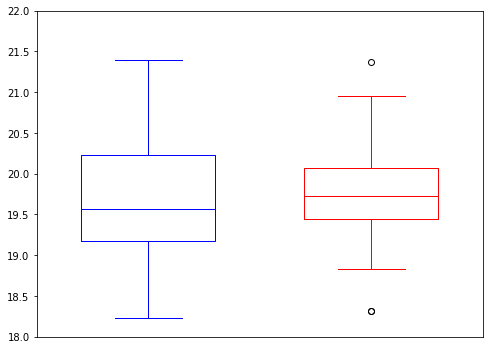

In [109]:
f = plt.figure(figsize=(8,6))
ax = f.gca()

# Plot boxes
bp = ax.boxplot([dice.values,f1.values],positions=[0,1], widths = 0.6)
setBoxColors(bp)
    
ax.set_xticks(tickvalues)
ax.set_xticklabels(ticklabels)
ax.set_ylim([18,22])

f.savefig('./figures/metric_boxplot_F1_new.svg')

In [91]:
onerror = (f1sc_as_metric.T-dice_as_metric.T).mean(axis=1)


In [92]:
onerror+offerror

UNet5Levels                            1.419167
UNet5LevelsConv                      -72.621667
UNet5LevelsConv_real                  -0.116667
UNet5LevelsConv_synth                 -0.424167
UNet5Levels_real                      -0.075000
UNet5Levels_synth                     -0.086667
UNet6Levels                            1.580000
UNet6LevelsConv                        0.235833
UNet6LevelsConv_real                  -0.590833
UNet6LevelsConv_synth                  0.501667
UNet6Levels_real                      -0.927500
UNet6Levels_synth                      0.356667
UNet7Levels                            0.455000
UNet7LevelsConv                        1.849167
UNet7LevelsConv_real                   0.477500
UNet7LevelsConv_synth                  0.753333
UNet7Levels_real                      -0.903333
UNet7Levels_synth                      1.410000
WNet5Levels                           -0.753333
WNet5LevelsConv                       -0.642500
WNet5LevelsConv_real                   0

In [47]:
tmp = (f1sc_as_metric-dice_as_metric)

In [60]:
tmp2 = tmp.filter(items=[n for n in tmp if ((not n == 'UNet6Levels') and (not n == 'UNet6Levels_synth') and
                                            (not n == 'UNet7Levels') and (not n == 'UNet7Levels_synth'))])

In [62]:
tmp2.mean(axis=1)

P_qtdb_single     -0.215862
QRS_qtdb_single    0.084483
T_qtdb_single      0.518966
P_qtdb_multi      -0.245517
QRS_qtdb_multi     0.022414
T_qtdb_multi       0.681034
P_zhejiang         0.062414
QRS_zhejiang       0.030690
T_zhejiang         0.224828
P_ludb            -0.352759
QRS_ludb           0.005862
T_ludb             0.094828
dtype: float64

# SelfAttention vs Not

In [140]:
metric = "F1 Score"
# metric = "Onset Error (STD)"
# metric = "Offset Error (STD)"

selfatt = [model for model in valid_models if ("SelfAttentionConv" in model)]
noselfatt = [model for model in valid_models if ("SelfAttentionConv" not in model)]

selfatt_as_metric = {}
noselfatt_as_metric = {}

for db in all_databases:
    database = eval(db)
    
    for k in database:
        value = {wave: database[k][wave][metric] for wave in all_waves}
        unikey = "_".join(k.replace("SelfAttentionConv","").split("_")[:-1])
        
        if k in selfatt:
            value = selfatt_as_metric.get(unikey,{})
            value.update({f"{wave}_{db}": database[k][wave][metric] for wave in all_waves})
            selfatt_as_metric[unikey] = value
        elif k in noselfatt:
            value = noselfatt_as_metric.get(unikey,{})
            value.update({f"{wave}_{db}": database[k][wave][metric] for wave in all_waves})
            noselfatt_as_metric[unikey] = value
        else:
            raise ValueError("This should not have happened")

# Convert to DataFrame
selfatt_as_metric = pd.DataFrame(selfatt_as_metric)
noselfatt_as_metric = pd.DataFrame(noselfatt_as_metric)

# Display results
print(("noselfatt VS selfatt", (noselfatt_as_metric.T-selfatt_as_metric.T).mean(axis=1).mean()))
print("\n")
print("\n")
print("\n")

# Per wave
for wave in all_waves:
    selfatt_mtr = selfatt_as_metric.T[[f'{wave}_qtdb_single',f'{wave}_qtdb_multi',f'{wave}_ludb',f'{wave}_zhejiang',]].T
    noselfatt_mtr = noselfatt_as_metric.T[[f'{wave}_qtdb_single',f'{wave}_qtdb_multi',f'{wave}_ludb',f'{wave}_zhejiang',]].T
    print(f"########## {wave} wave ##########")
    print(("noselfatt VS selfatt", (noselfatt_mtr.T-selfatt_mtr.T).mean(axis=1).mean()))
    print("\n")

print("\n")
print("\n")

# Per database
for db in all_databases:
    selfatt_mtr = selfatt_as_metric.T[[f"P_{db}",f"QRS_{db}",f"T_{db}"]].T
    noselfatt_mtr = noselfatt_as_metric.T[[f"P_{db}",f"QRS_{db}",f"T_{db}"]].T
    print(f"########## {db} database ##########")
    print(("noselfatt VS selfatt", (noselfatt_mtr.T-selfatt_mtr.T).mean(axis=1).mean()))
    print("\n")


('noselfatt VS selfatt', 0.08263888888888853)






########## P wave ##########
('noselfatt VS selfatt', 0.06291666666666688)


########## QRS wave ##########
('noselfatt VS selfatt', 0.08333333333333155)


########## T wave ##########
('noselfatt VS selfatt', 0.10166666666666717)






########## qtdb_single database ##########
('noselfatt VS selfatt', 0.11111111111110876)


########## qtdb_multi database ##########
('noselfatt VS selfatt', 0.1772222222222237)


########## zhejiang database ##########
('noselfatt VS selfatt', 0.1494444444444443)


########## ludb database ##########
('noselfatt VS selfatt', -0.10722222222222261)




# Levels

In [142]:
metric = "F1 Score"
metric = "Onset Error (STD)"
metric = "Offset Error (STD)"

level5 = [model for model in valid_models if ("5Levels" in model)]
level6 = [model for model in valid_models if ("6Levels" in model)]
level7 = [model for model in valid_models if ("7Levels" in model)]


level5_as_metric = {}
level6_as_metric = {}
level7_as_metric = {}

for db in all_databases:
    database = eval(db)
    
    for k in database:
        value = {wave: database[k][wave][metric] for wave in all_waves}
        unikey = "_".join(k.split('_')[:-1]).replace("5Levels","").replace("6Levels","").replace("7Levels","")
        
        if k in level5:
            value = level5_as_metric.get(unikey,{})
            value.update({f"{wave}_{db}": database[k][wave][metric] for wave in all_waves})
            level5_as_metric[unikey] = value
        elif k in level6:
            value = level6_as_metric.get(unikey,{})
            value.update({f"{wave}_{db}": database[k][wave][metric] for wave in all_waves})
            level6_as_metric[unikey] = value
        elif k in level7:
            value = level7_as_metric.get(unikey,{})
            value.update({f"{wave}_{db}": database[k][wave][metric] for wave in all_waves})
            level7_as_metric[unikey] = value
        else:
            raise ValueError("This should not have happened")

# Convert to DataFrame
level5_as_metric = pd.DataFrame(level5_as_metric)
level6_as_metric = pd.DataFrame(level6_as_metric)
level7_as_metric = pd.DataFrame(level7_as_metric)

# Display results
print(("level7 VS level5", (level7_as_metric.T-level5_as_metric.T).mean(axis=1).mean()))
print(("level7 VS level6", (level7_as_metric.T-level6_as_metric.T).mean(axis=1).mean()))
print(("level6 VS level5", (level6_as_metric.T-level5_as_metric.T).mean(axis=1).mean()))
print("\n")
print("\n")
print("\n")

# Per wave
for wave in all_waves:
    level5_mtr = eval(f"level5_as_metric").T[[f'{wave}_qtdb_single',f'{wave}_qtdb_multi',f'{wave}_ludb',f'{wave}_zhejiang',]].T
    level6_mtr = eval(f"level6_as_metric").T[[f'{wave}_qtdb_single',f'{wave}_qtdb_multi',f'{wave}_ludb',f'{wave}_zhejiang',]].T
    level7_mtr = eval(f"level7_as_metric").T[[f'{wave}_qtdb_single',f'{wave}_qtdb_multi',f'{wave}_ludb',f'{wave}_zhejiang',]].T
    print(f"########## {wave} wave ##########")
    print(("level7 VS level5", (level7_mtr.T-level5_mtr.T).mean(axis=1).mean()))
    print(("level7 VS level6", (level7_mtr.T-level6_mtr.T).mean(axis=1).mean()))
    print(("level6 VS level5", (level6_mtr.T-level5_mtr.T).mean(axis=1).mean()))
    print("\n")

print("\n")
print("\n")

# Per database
for db in all_databases:
    level5_mtr = level5_as_metric.T[[f"P_{db}",f"QRS_{db}",f"T_{db}"]].T
    level6_mtr = level6_as_metric.T[[f"P_{db}",f"QRS_{db}",f"T_{db}"]].T
    level7_mtr = level7_as_metric.T[[f"P_{db}",f"QRS_{db}",f"T_{db}"]].T
    print(f"########## {db} database ##########")
    print(("level7 VS level5", (level7_mtr.T-level5_mtr.T).mean(axis=1).mean()))
    print(("level7 VS level6", (level7_mtr.T-level6_mtr.T).mean(axis=1).mean()))
    print(("level6 VS level5", (level6_mtr.T-level5_mtr.T).mean(axis=1).mean()))
    print("\n")


('level7 VS level5', -3.153541666666666)
('level7 VS level6', 0.03986111111111093)
('level6 VS level5', -2.2129629629629637)






########## P wave ##########
('level7 VS level5', -2.522708333333334)
('level7 VS level6', 0.01145833333333294)
('level6 VS level5', -1.9123611111111112)


########## QRS wave ##########
('level7 VS level5', -2.264583333333334)
('level7 VS level6', 0.04895833333333335)
('level6 VS level5', -1.6081944444444445)


########## T wave ##########
('level7 VS level5', -4.673333333333335)
('level7 VS level6', 0.05916666666666651)
('level6 VS level5', -3.118333333333334)






########## qtdb_single database ##########
('level7 VS level5', 0.46749999999999964)
('level7 VS level6', 0.07694444444444418)
('level6 VS level5', 0.057592592592592445)


########## qtdb_multi database ##########
('level7 VS level5', 0.6288888888888887)
('level7 VS level6', -0.12750000000000028)
('level6 VS level5', 0.32185185185185167)


########## zhejiang database ##########
('level7 VS le

# Fix Zhejiang's and LUDB's mistake at computing on/off error

In [161]:
def get_ground_truth(basedir: str, database: str):
    if database == 'ludb':
        # Load data
        P = sak.load_data(os.path.join(basedir,"ludb","P.csv"))
        QRS = sak.load_data(os.path.join(basedir,"ludb","QRS.csv"))
        T = sak.load_data(os.path.join(basedir,"ludb","T.csv"))
    elif database == 'zhejiang':
        # Load data
        P = sak.load_data(os.path.join(basedir,"ZhejiangDB","P.csv"))
        QRS = sak.load_data(os.path.join(basedir,"ZhejiangDB","QRS.csv"))
        T = sak.load_data(os.path.join(basedir,"ZhejiangDB","T.csv"))
        
    # Divide into onsets/offsets
    Pon    = {k: P[k][0::2] for k in P}
    Poff   = {k: P[k][1::2] for k in P}
    QRSon  = {k: QRS[k][0::2] for k in QRS}
    QRSoff = {k: QRS[k][1::2] for k in QRS}
    Ton    = {k: T[k][0::2] for k in T}
    Toff   = {k: T[k][1::2] for k in T}

    # Generate validity
    validity = {
        k: [
            np.min(np.concatenate((P.get(k,[+np.inf]),QRS.get(k,[+np.inf]),T.get(k,[+np.inf])))),
            np.max(np.concatenate((P.get(k,[-np.inf]),QRS.get(k,[-np.inf]),T.get(k,[-np.inf])))),
        ] for k in QRS
    }
    return Pon,Poff,QRSon,QRSoff,Ton,Toff,validity
 
def get_file_list(basedir: str, database: str):
    if database == 'ludb':
        files = glob.glob(os.path.join(basedir,'ludb','*.dat'))
    elif database == 'zhejiang':
        files = glob.glob(os.path.join(basedir,'ZhejiangDB','RAW','*.csv'))
    return files
 
def get_sample(file: str, database: str):
    if database == 'ludb':
        (signal, header) = wfdb.rdsamp(os.path.splitext(file)[0])
        fs = header['fs']
    elif database == 'zhejiang':
        signal = pd.read_csv(file).values
        fs = 2000.
    return signal, fs


In [166]:
target_fs = {"ludb": 500, "zhejiang": 2000}

In [188]:
for folder in tqdm.tqdm(folders):
    if (
        (not os.path.isfile(os.path.join(folder,'metrics_string.txt'))) or
        (not os.path.isfile(os.path.join(folder,'zhejiang_metrics_string.txt'))) or
        (not os.path.isfile(os.path.join(folder,'ludb_metrics_string.txt'))) or
        (not os.path.isfile(os.path.join(folder,'metrics_fold_string.txt')))
       ):
        continue
    
    for db in ["zhejiang", "ludb"]:
        # Get predicted GT
        pon    = sak.load_data(os.path.join(folder,f"{db}_predicted_pon.csv"))
        poff   = sak.load_data(os.path.join(folder,f"{db}_predicted_poff.csv"))
        qrson  = sak.load_data(os.path.join(folder,f"{db}_predicted_qrson.csv"))
        qrsoff = sak.load_data(os.path.join(folder,f"{db}_predicted_qrsoff.csv"))
        ton    = sak.load_data(os.path.join(folder,f"{db}_predicted_ton.csv"))
        toff   = sak.load_data(os.path.join(folder,f"{db}_predicted_toff.csv"))

        # Get true fiducials
        Pon,Poff,QRSon,QRSoff,Ton,Toff,validity = get_ground_truth(basedir, db)

        # Produce metrics
        metrics = {}

        for wave in ['p','qrs','t']:
            metrics[wave] = {}
            metrics[wave]['truepositives'] = {}
            metrics[wave]['falsepositives'] = {}
            metrics[wave]['falsenegatives'] = {}
            metrics[wave]['onerrors'] = {}
            metrics[wave]['offerrors'] = {}

            input_on   = eval('{}on'.format(wave.lower()))
            input_off  = eval('{}off'.format(wave.lower()))
            target_on  = eval('{}on'.format(wave.upper()))
            target_off = eval('{}off'.format(wave.upper()))

            # Compute metrics
            for k_input in input_on:
                k_target = f"{k_input}###I"
                try:
                    # Refine input and output's regions w/ validity vectors
                    (input_on[k_input],input_off[k_input]) = src.metrics.filter_valid(input_on[k_input],input_off[k_input], validity[k_target][0], validity[k_target][1],operation="or")
                    (target_on[k_target],target_off[k_target]) = src.metrics.filter_valid(target_on[k_target],target_off[k_target], validity[k_target][0], validity[k_target][1],operation="or")
                    tp,fp,fn,dice,onerror,offerror = src.metrics.compute_metrics(input_on[k_input],input_off[k_input],target_on[k_target],target_off[k_target])
                except:
                    continue
                metrics[wave]['truepositives'][k_input] = tp
                metrics[wave]['falsepositives'][k_input] = fp
                metrics[wave]['falsenegatives'][k_input] = fn
                metrics[wave]['onerrors'][k_input] = np.copy(np.array(onerror))
                metrics[wave]['offerrors'][k_input] = np.copy(np.array(offerror))

        #########################################################################
        # Get stupid metric string
        metrics_string = ""
        metrics_string += "\n# {}".format(model_name)

        for wave in ['p','qrs','t']:
            metrics_string += "\n######### {} wave #########".format(wave.upper())
            metrics_string += "\n"
            metrics_string += "\nPrecision:    {}%".format(np.round(src.metrics.precision(sum(metrics[wave]['truepositives'].values()),sum(metrics[wave]['falsepositives'].values()),sum(metrics[wave]['falsenegatives'].values()))*100,decimals=2))
            metrics_string += "\nRecall:       {}%".format(np.round(src.metrics.recall(sum(metrics[wave]['truepositives'].values()),sum(metrics[wave]['falsepositives'].values()),sum(metrics[wave]['falsenegatives'].values()))*100,decimals=2))
            metrics_string += "\nF1 score:     {}%".format(np.round(src.metrics.f1_score(sum(metrics[wave]['truepositives'].values()),sum(metrics[wave]['falsepositives'].values()),sum(metrics[wave]['falsenegatives'].values()))*100,decimals=2))
            metrics_string += "\n"
            metrics_string += "\nOnset Error:  {} ± {} ms".format(np.round(np.mean([v for l in metrics[wave]['onerrors'].values() for v in l])/target_fs[db]*1000,decimals=2),np.round(np.std([v for l in metrics[wave]['onerrors'].values() for v in l])/target_fs[db]*1000,decimals=2))
            metrics_string += "\nOffset Error: {} ± {} ms".format(np.round(np.mean([v for l in metrics[wave]['offerrors'].values() for v in l])/target_fs[db]*1000,decimals=2),np.round(np.std([v for l in metrics[wave]['offerrors'].values() for v in l])/target_fs[db]*1000,decimals=2))
            metrics_string += "\n\n"

        metrics_string += "\n---"

        
        # Save produced metrics
        original_stdout = sys.stdout # Save a reference to the original standard output
        with open(os.path.join(folder,f'{db}_metrics_string.txt'), 'w') as f:
            sys.stdout = f # Change the standard output to the file we created.
            print(metrics_string)

        sys.stdout = original_stdout # Reset the standard output to its original value


100%|██████████| 109/109 [00:42<00:00,  2.58it/s]


In [170]:
# Get predicted GT
pon    = sak.load_data(os.path.join(folder,f"{db}_predicted_pon.csv"))
poff   = sak.load_data(os.path.join(folder,f"{db}_predicted_poff.csv"))
qrson  = sak.load_data(os.path.join(folder,f"{db}_predicted_qrson.csv"))
qrsoff = sak.load_data(os.path.join(folder,f"{db}_predicted_qrsoff.csv"))
ton    = sak.load_data(os.path.join(folder,f"{db}_predicted_ton.csv"))
toff   = sak.load_data(os.path.join(folder,f"{db}_predicted_toff.csv"))

# Get true fiducials
Pon,Poff,QRSon,QRSoff,Ton,Toff,validity = get_ground_truth(basedir, 'zhejiang')

In [171]:
# Produce metrics
metrics = {}

for wave in ['p','qrs','t']:
    metrics[wave] = {}
    metrics[wave]['truepositives'] = {}
    metrics[wave]['falsepositives'] = {}
    metrics[wave]['falsenegatives'] = {}
    metrics[wave]['onerrors'] = {}
    metrics[wave]['offerrors'] = {}

    input_on   = eval('{}on'.format(wave.lower()))
    input_off  = eval('{}off'.format(wave.lower()))
    target_on  = eval('{}on'.format(wave.upper()))
    target_off = eval('{}off'.format(wave.upper()))

    # Compute metrics
    for k_input in input_on:
        k_target = f"{k_input}###I"
        try:
            # Refine input and output's regions w/ validity vectors
            (input_on[k_input],input_off[k_input]) = src.metrics.filter_valid(input_on[k_input],input_off[k_input], validity[k_target][0], validity[k_target][1],operation="or")
            (target_on[k_target],target_off[k_target]) = src.metrics.filter_valid(target_on[k_target],target_off[k_target], validity[k_target][0], validity[k_target][1],operation="or")
            tp,fp,fn,dice,onerror,offerror = src.metrics.compute_metrics(input_on[k_input],input_off[k_input],target_on[k_target],target_off[k_target])
        except:
            continue
        metrics[wave]['truepositives'][k_input] = tp
        metrics[wave]['falsepositives'][k_input] = fp
        metrics[wave]['falsenegatives'][k_input] = fn
        metrics[wave]['onerrors'][k_input] = np.copy(np.array(onerror))
        metrics[wave]['offerrors'][k_input] = np.copy(np.array(offerror))


In [180]:
#########################################################################
# Get stupid metric string
metrics_string = ""
metrics_string += "\n# {}".format(model_name)

for wave in ['p','qrs','t']:
    metrics_string += "\n######### {} wave #########".format(wave.upper())
    metrics_string += "\n"
    metrics_string += "\nPrecision:    {}%".format(np.round(src.metrics.precision(sum(metrics[wave]['truepositives'].values()),sum(metrics[wave]['falsepositives'].values()),sum(metrics[wave]['falsenegatives'].values()))*100,decimals=2))
    metrics_string += "\nRecall:       {}%".format(np.round(src.metrics.recall(sum(metrics[wave]['truepositives'].values()),sum(metrics[wave]['falsepositives'].values()),sum(metrics[wave]['falsenegatives'].values()))*100,decimals=2))
    metrics_string += "\nF1 score:     {}%".format(np.round(src.metrics.f1_score(sum(metrics[wave]['truepositives'].values()),sum(metrics[wave]['falsepositives'].values()),sum(metrics[wave]['falsenegatives'].values()))*100,decimals=2))
    metrics_string += "\n"
    metrics_string += "\nOnset Error:  {} ± {} ms".format(np.round(np.mean([v for l in metrics[wave]['onerrors'].values() for v in l])/target_fs[db]*1000,decimals=2),np.round(np.std([v for l in metrics[wave]['onerrors'].values() for v in l])/target_fs[db]*1000,decimals=2))
    metrics_string += "\nOffset Error: {} ± {} ms".format(np.round(np.mean([v for l in metrics[wave]['offerrors'].values() for v in l])/target_fs[db]*1000,decimals=2),np.round(np.std([v for l in metrics[wave]['offerrors'].values() for v in l])/target_fs[db]*1000,decimals=2))
    metrics_string += "\n\n"

metrics_string += "\n---"


In [183]:
db

'zhejiang'

In [182]:
os.path.join(folder,f'{db}_metrics_string.txt'),

'/media/guille/DADES/DADES/Delineator/TrainedModels/UNet5LevelsConvDiceOnly_real_20201204204042'

In [184]:
shutil.copy(os.path.join(folder,f'{db}_metrics_string.txt'),os.path.join(folder,f'{db}_metrics_string_pre_fix.txt'))

'/media/guille/DADES/DADES/Delineator/TrainedModels/UNet5LevelsConvDiceOnly_real_20201204204042/zhejiang_metrics_string_pre_fix.txt'

In [181]:
print(metrics_string)


# UNet5LevelsConvDiceOnly_synth_20201211065325
######### P wave #########

Precision:    98.35%
Recall:       94.96%
F1 score:     96.62%

Onset Error:  3.3 ± 14.38 ms
Offset Error: 9.79 ± 12.63 ms


######### QRS wave #########

Precision:    99.13%
Recall:       99.66%
F1 score:     99.4%

Onset Error:  -0.29 ± 13.13 ms
Offset Error: 4.82 ± 11.68 ms


######### T wave #########

Precision:    94.85%
Recall:       98.85%
F1 score:     96.81%

Onset Error:  0.94 ± 34.25 ms
Offset Error: -3.23 ± 35.53 ms


---


# TMP

In [5]:
def get_ground_truth(basedir: str, database: str):
    if database == 'ludb':
        # Load data
        P = sak.load_data(os.path.join(basedir,"ludb","P.csv"))
        QRS = sak.load_data(os.path.join(basedir,"ludb","QRS.csv"))
        T = sak.load_data(os.path.join(basedir,"ludb","T.csv"))
    elif database == 'zhejiang':
        # Load data
        P = sak.load_data(os.path.join(basedir,"ZhejiangDB","P.csv"))
        QRS = sak.load_data(os.path.join(basedir,"ZhejiangDB","QRS.csv"))
        T = sak.load_data(os.path.join(basedir,"ZhejiangDB","T.csv"))
        
    # Divide into onsets/offsets
    Pon    = {k: P[k][0::2] for k in P}
    Poff   = {k: P[k][1::2] for k in P}
    QRSon  = {k: QRS[k][0::2] for k in QRS}
    QRSoff = {k: QRS[k][1::2] for k in QRS}
    Ton    = {k: T[k][0::2] for k in T}
    Toff   = {k: T[k][1::2] for k in T}

    # Generate validity
    validity = {
        k: [
            np.min(np.concatenate((P.get(k,[+np.inf]),QRS.get(k,[+np.inf]),T.get(k,[+np.inf])))),
            np.max(np.concatenate((P.get(k,[-np.inf]),QRS.get(k,[-np.inf]),T.get(k,[-np.inf])))),
        ] for k in QRS
    }
    return Pon,Poff,QRSon,QRSoff,Ton,Toff,validity
 
def get_file_list(basedir: str, database: str):
    if database == 'ludb':
        files = glob.glob(os.path.join(basedir,'ludb','*.dat'))
    elif database == 'zhejiang':
        files = glob.glob(os.path.join(basedir,'ZhejiangDB','RAW','*.csv'))
    return files
 
def get_sample(file: str, database: str):
    if database == 'ludb':
        (signal, header) = wfdb.rdsamp(os.path.splitext(file)[0])
        fs = header['fs']
    elif database == 'zhejiang':
        signal = pd.read_csv(file).values
        fs = 2000.
    return signal, fs


In [7]:
basedir = '/media/guille/DADES/DADES/Delineator/'
_,_,QRSon,QRSoff,_,_,_ = get_ground_truth(basedir,"ludb")

In [32]:
QRSon  = sak.load_data(os.path.join(basedir, 'QTDB', 'QRSonNew.csv'))

In [36]:
sum([QRSon[k].size for k in QRSon])//2

3295

In [8]:
counter = 0

for k in QRSon:
    if k.endswith("###I"):
        counter += QRSon[k].size

In [30]:
counter = 0

for file in glob.glob('/media/guille/DADES/DADES/PhysioNet/QTDB/RAW/*.q1c'):
    fname,ext = os.path.splitext(file)
    ext = ext.replace('.','')
    
    ann = wfdb.rdann(fname,ext)
    counter += (np.array(ann.symbol) == 'N').sum()


In [31]:
counter

3528

In [16]:
21966//12

1830

In [12]:
counter

611

In [393]:
file_list = get_file_list(basedir,"zhejiang")

In [399]:
samples = []

for file in file_list:
    sample,fs = get_sample(file,"zhejiang")
    
    samples.append(sample.shape[0])

In [403]:
min(samples)

5791

In [407]:
max(samples)/fs

22.622